# Homework #6

## Performance measures

This colaboratory also contains **Homework #6** of the Machine Learning course, which is due **December 8, midnight (23:59 EET time)**. To complete the homework, extract **(File -> Download .ipynb)** and submit to the course webpage.


## Submission's rules:

1.   Please, submit only .ipynb that you extract from the Colaboratory.
2. Run your homework exercises before submitting (output should be present, preferably restart the kernel and press run all the cells).
3. Do not change the description of tasks in red (even if there is a typo|mistake|etc).
4. Please, make sure to avoid unnecessary long printouts.
5. Each task should be solved right under the question of the task and not elsewhere.
6. Solutions to both regular and bonus exercises should be submitted in one IPYNB file.

Please, steer clear of copying someone else's work. If you discuss assignments with anyone in the course, please, mention their names here:

Pooh

##List of Homework's exercises:

1.   [Ex1](#scrollTo=Va-cdXRPJ0qZ) - 3 points
2.   [Ex2](#scrollTo=lbbE3lltHbA_) - 3 points
3.   [Ex3](#scrollTo=NCdZudhH_WJc) - 4 points


In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# For plotting like a pro (actually, no)
!pip install -q plotnine
from plotnine import *

<font color='red'> **Preparing the dataset for this homework.** We will be using the 'Credit-g' dataset from OpenML. This dataset classifies people described by a set of attributes as good or bad credit risks. To prepare the data for training, we will complete several prepropressing steps: impute the missing values (we will use [`sklearn Simple Imputer`](https://scikit-learn.org/1.5/modules/impute.html )), handle numerical and categorical features (`OneHotEncoder()` for categorical features and `StandardScaler()` for numerical) and split into training and test sets. **NB! We split data into train and validation before performing other preprocessing steps, this is important to avoid data leakage.**

In [2]:
from sklearn.datasets import fetch_openml

# Fetching 'Credit-g' dataset from OpenML
# https://www.openml.org/search?type=data&sort=runs&id=31
dataset = fetch_openml(name='credit-g')

In [3]:
dataset.data.describe(include = 'all') # explore the dataset

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
count,1000,1000.000000,1000,1000,1000.000000,1000,1000,1000.000000,1000,1000,1000.000000,1000,1000.000000,1000,1000,1000.000000,1000,1000.000000,1000,1000
unique,4,NaN,5,10,NaN,5,5,NaN,4,3,NaN,4,NaN,3,3,NaN,4,NaN,2,2
top,no checking,NaN,existing paid,radio/tv,NaN,<100,1<=X<4,NaN,male single,none,NaN,car,NaN,none,own,NaN,skilled,NaN,none,yes
freq,394,NaN,530,280,NaN,603,339,NaN,548,907,NaN,332,NaN,814,713,NaN,630,NaN,596,963
mean,NaN,20.903000,NaN,NaN,3271.258000,NaN,NaN,2.973000,NaN,NaN,2.845000,NaN,35.546000,NaN,NaN,1.407000,NaN,1.155000,NaN,NaN
std,NaN,12.058814,NaN,NaN,2822.736876,NaN,NaN,1.118715,NaN,NaN,1.103718,NaN,11.375469,NaN,NaN,0.577654,NaN,0.362086,NaN,NaN
min,NaN,4.000000,NaN,NaN,250.000000,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,19.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN
25%,NaN,12.000000,NaN,NaN,1365.500000,NaN,NaN,2.000000,NaN,NaN,2.000000,NaN,27.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN
50%,NaN,18.000000,NaN,NaN,2319.500000,NaN,NaN,3.000000,NaN,NaN,3.000000,NaN,33.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN
75%,NaN,24.000000,NaN,NaN,3972.250000,NaN,NaN,4.000000,NaN,NaN,4.000000,NaN,42.000000,NaN,NaN,2.000000,NaN,1.000000,NaN,NaN


In [4]:
# Convert to DataFrame for easier analysis
data = pd.DataFrame(data=dataset.data)
target = pd.DataFrame(dataset.target)

<font color='red'> Splitting the dataset into training and test sets. Note that we do it before all other transformations.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Here we use a more fancy way to transform our data using Pipeline class
# from sklearn https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

# First let's identify which variables are numeric and categorical
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object', 'category']).columns

# Defining a sequence of transformations for numeric variables
# We first impute missing values using median and then standardize
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Then define a sequence of transformations for categorical variables...
# Imputing missing values using the most frequent value and then convert into
# OneHotEncoded format
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Putting transformations together for both types of variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

<font color='red'> Here we first configure and apply preprocessing transformations first on the train subset and only then apply these transformations to test.

In [7]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"Shape of X_train_transformed: {X_train_transformed.shape}")
print(f"Shape of X_test_transformed: {X_test_transformed.shape}")

Shape of X_train_transformed: (700, 61)
Shape of X_test_transformed: (300, 61)


In [8]:
import matplotlib.pyplot as plt

# We will re-use this code in the future
def plot_class_distribution(y, title="Class Distribution"):

    class_counts = y.value_counts()

    class_counts.plot(kind='bar', color=['skyblue', 'orange'])
    plt.title(title, fontsize=14)
    plt.xlabel("Class", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=0, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

<font color='red'> Let's take a look at the class distribution of this dataset.

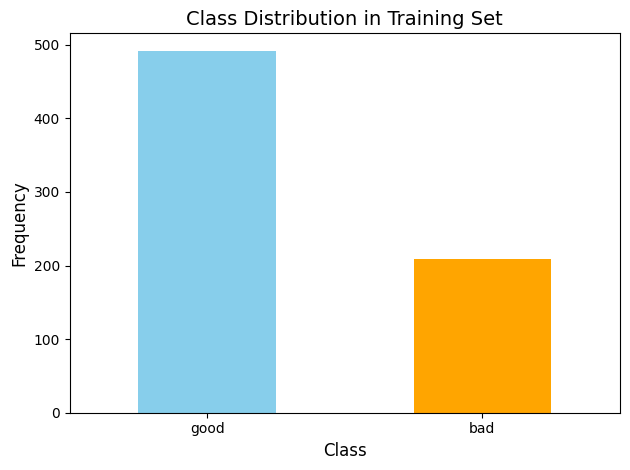

In [9]:
plot_class_distribution(y_train['class'], title="Class Distribution in Training Set")

<font color='red'> This is a classical example of the unbalanced dataset i.e. one of the classes is twice or more prevalent than the other.</font>



---

## Homework exercise 1: compute macro and weighted averages for precision, recall and f1-score on an unbalanced dataset (3 points)


<font color='red'> In this exercise we will calculate ordinary recall, precision and f1 measures and their macro- and weighted average versions. Learn more about macro and weighted averages here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html  </font>


In [10]:
# train a classifier
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(max_iter=10000, random_state=13)
logit.fit(X_train_transformed, y_train['class'])

# predicting on test
predictions_logit = logit.predict(X_test_transformed)

In [ ]:
print(predictions_logit[:10])

<font color='red'>  **(Homework exercise 1- a)** Fill in the gaps to complete a function that calculates `tp`, `fn`, `fp`, `tn` depending on which class is considered to be `positive`.  **(1 point)**</font>

In [11]:
import math

def compute_confusion_stats(classes, predictions, positive_class, negative_class):
  #### YOUR CODE STARTS ####
  tp = fn = fp = tn = 0

  # Iterate through true classes and predictions
  for true_class, predicted_class in zip(classes, predictions):
    if true_class == positive_class and predicted_class == positive_class:
        tp += 1  # True Positive
    elif true_class == positive_class and predicted_class == negative_class:
        fn += 1  # False Negative
    elif true_class == negative_class and predicted_class == positive_class:
        fp += 1  # False Positive
    elif true_class == negative_class and predicted_class == negative_class:
        tn += 1  # True Negative
  #### YOUR CODE ENDS ####

  return (tp, fn, fp, tn)

def compute_rec_prec_f1(tp, fn, fp, tn):
  recall = tp / (tp + fn)
  precision = tp / (tp + fp)
  f1 = 2 * recall * precision / (precision + recall)
  if math.isnan(f1):
    f1 = 0
  return (recall, precision, f1)

<font color='red'> Compute `tp`, `fn`, `fp`, `tn` and `recall`, `precision` and `f1` measures using functions `compute_confusion_stats` and `compute_rec_prec_f1` above. `recall`, `precision` and `f1` should be computed for both classes, e.g. `recall_good` is a recall when the `good` class is considered to be positive, `recall_bad` is a recall when the `bad` class is regarded as positive.</font>




In [12]:
# The 'good' class is considered positive
#### YOUR CODE STARTS ####
# The 'good' class is considered positive
tp_good, fn_good, fp_good, tn_good = compute_confusion_stats(y_test['class'], predictions_logit, positive_class='good', negative_class='bad')
recall_good, precision_good, f1_good = compute_rec_prec_f1(tp_good, fn_good, fp_good, tn_good)
#### YOUR CODE ENDS ####

print(f'Recall for the first class = {round(recall_good, 2)}')
print(f'Precision for the first class = {round(precision_good, 2)}')
print(f'F1 score for the first class = {round(f1_good, 2)}')

Recall for the first class = 0.9
Precision for the first class = 0.8
F1 score for the first class = 0.85


In [13]:
# The 'bad' class is considered positive
#### YOUR CODE STARTS ####
# The 'bad' class is considered positive
tp_bad, fn_bad, fp_bad, tn_bad = compute_confusion_stats(y_test['class'], predictions_logit, positive_class='bad', negative_class='good')
recall_bad, precision_bad, f1_bad = compute_rec_prec_f1(tp_bad, fn_bad, fp_bad, tn_bad)
#### YOUR CODE ENDS ####

print(f'Recall for the second class = {round(recall_bad, 2)}')
print(f'Precision for the second class = {round(precision_bad, 2)}')
print(f'F1 score for the second class = {round(f1_bad, 2)}')

Recall for the second class = 0.48
Precision for the second class = 0.68
F1 score for the second class = 0.56


<font color='red'>  **(Homework exercise 1- b)** Without using any external libraries, calculate macro and weighted averages for all metrics. Run the `classification_report` function from `sklearn`, make sure that the outputs match. **(1 point)**</font>

In [14]:
#### YOUR CODE STARTS ####
# Calculate macro averages
recall_macro = (recall_good + recall_bad) / 2
precision_macro = (precision_good + precision_bad) / 2
f1_macro = (f1_good + f1_bad) / 2

# Calculate class-specific metrics
metrics_good = (recall_good, precision_good, f1_good)
metrics_bad = (recall_bad, precision_bad, f1_bad)

#### YOUR CODE ENDS ####

In [15]:
#### YOUR CODE STARTS ####
# Calculate class weights based on the number of instances in each class
# Get class counts
total_instances = len(y_test['class'])
class_counts = {label: y_test['class'].tolist().count(label) for label in set(y_test['class'])}

# Weighted averages (weighted mean of metric values)
recall_weighted = (recall_good * class_counts['good'] + recall_bad * class_counts['bad']) / total_instances
precision_weighted = (precision_good * class_counts['good'] + precision_bad * class_counts['bad']) / total_instances
f1_weighted = (f1_good * class_counts['good'] + f1_bad * class_counts['bad']) / total_instances

#### YOUR CODE ENDS ####

In [16]:
print(f"Macro Recall: {round(recall_macro, 2)}")
print(f"Macro Precision: {round(precision_macro, 2)}")
print(f"Macro F1: {round(f1_macro, 2)}")
print(f"Weighted Recall: {round(recall_weighted, 2)}")
print(f"Weighted Precision: {round(precision_weighted, 2)}")
print(f"Weighted F1: {round(f1_weighted, 2)}")

Macro Recall: 0.69
Macro Precision: 0.74
Macro F1: 0.71
Weighted Recall: 0.77
Weighted Precision: 0.76
Weighted F1: 0.76


<font color='red'>  Compare all your results with the output of `classification_report` function. Make sure they are the same. </font>

In [17]:
from sklearn.metrics import classification_report

#### YOUR CODE STARTS ####
print(classification_report(y_test['class'], predictions_logit, digits=2))
#### YOUR CODE ENDS ####


              precision    recall  f1-score   support

         bad       0.68      0.48      0.56        91
        good       0.80      0.90      0.85       209

    accuracy                           0.77       300
   macro avg       0.74      0.69      0.71       300
weighted avg       0.76      0.77      0.76       300



<font color='red'>  **(Homework exercise 1- c)** Use a different classifier on the same dataset. Calculate only weighted- and macro- average f1 score as we have just done for `LogisticRegression`. Compare the obtained results to figure out which classifier is better. **(1 point)**</font>

In [18]:
#### YOUR CODE STARTS ####
from sklearn.ensemble import RandomForestClassifier

# Train a different classifier (RandomForest)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=13)
rf_clf.fit(X_train_transformed, y_train['class'])
predictions_rf = rf_clf.predict(X_test_transformed)

# Calculate metrics for the 'good' class
tp_good_rf, fn_good_rf, fp_good_rf, tn_good_rf = compute_confusion_stats(y_test['class'], predictions_rf, positive_class='good', negative_class='bad')
_, _, f1_good_rf = compute_rec_prec_f1(tp_good_rf, fn_good_rf, fp_good_rf, tn_good_rf)

# Calculate metrics for the 'bad' class
tp_bad_rf, fn_bad_rf, fp_bad_rf, tn_bad_rf = compute_confusion_stats(y_test['class'], predictions_rf, positive_class='bad', negative_class='good')
_, _, f1_bad_rf = compute_rec_prec_f1(tp_bad_rf, fn_bad_rf, fp_bad_rf, tn_bad_rf)

# Macro average F1
macro_avg_f1_rf = (f1_good_rf + f1_bad_rf) / 2

# Calculate weighted averages
# Weighted average F1
class_counts = {label: y_test['class'].tolist().count(label) for label in set(y_test['class'])}
total_instances = len(y_test['class'])

weighted_avg_f1_rf = (f1_good_rf * class_counts['good'] + f1_bad_rf * class_counts['bad']) / total_instances

print(f'Weighted averaging for f1 = {np.round(weighted_avg_f1_rf, 2)}')
#### YOUR CODE ENDS ####

Weighted averaging for f1 = 0.72


In [19]:
# Print results for RandomForest
print(f"RandomForest Macro F1: {round(macro_avg_f1_rf, 2)}")
print(f"RandomForest Weighted F1: {round(weighted_avg_f1_rf, 2)}")

# Comparison with Logistic Regression
print("\nComparison:")
print(f"Logistic Regression Macro F1: {round(f1_macro, 2)}")
print(f"Logistic Regression Weighted F1: {round(f1_weighted, 2)}")

# Decision on the better classifier
better_classifier = "RandomForest" if weighted_avg_f1_rf > f1_weighted else "Logistic Regression"
print(f"\nBetter classifier based on Weighted F1: {better_classifier}")

RandomForest Macro F1: 0.64
RandomForest Weighted F1: 0.72

Comparison:
Logistic Regression Macro F1: 0.71
Logistic Regression Weighted F1: 0.76

Better classifier based on Weighted F1: Logistic Regression




---

## Homework exercise 2: compare multiple classification methods using precision-recall curve (3 points)


<font color='red'> In the lecture and practice session we have discussed how receiver operating characteristic (ROC) and the corresponding area under this curve (AUC) can be used to assess classifier's performance. Although, being super popular and in majority cases adequate, ROC AUC can be overly optimistic when used on classifiers trained on severely imbalanced data. Another metric, namely - Precision-Recall Curve (PRC) is considered more appropriate for such data. In this exercise, we will learn to build PRC and use it to evaluate already familiar classifiers. Check out [this page](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/) if you want to know more about PRCs. </font>



<font color='red'>  **(Homework exercise 2- a)** Train three models (logistic regression, KNN and random forest) on the dataset from EX1. Calculate accuracy for each model on validation set using function `score` and model objects. Treat `good` as negative class and `bad` as positive. Separately, compute and print out the accuracy of the majority class classifier (*hint*: you can use `DummyClassifier` from `sklearn` to imitate majority class classifier).  **(1 point)**</font>

In [22]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

np.random.seed(1111) # random seed for consistency

#### YOUR CODE STARTS ####
# Initialize classifiers
logit = LogisticRegression(max_iter=10000, random_state=1111)
knn = KNeighborsClassifier()
rf = RandomForestClassifier(random_state=1111)
dummy = DummyClassifier(strategy='most_frequent', random_state=1111)

# Train classifiers on training data
logit.fit(X_train_transformed, y_train['class'])
knn.fit(X_train_transformed, y_train['class'])
rf.fit(X_train_transformed, y_train['class'])
dummy.fit(X_train_transformed, y_train['class'])
#### YOUR CODE ENDS ####

DummyClassifier(random_state=1111, strategy='most_frequent')

In [23]:
#### YOUR CODE STARTS ####
# Calculate accuracy on validation set
logit_acc = logit.score(X_test_transformed, y_test['class'])
knn_acc = knn.score(X_test_transformed, y_test['class'])
rf_acc = rf.score(X_test_transformed, y_test['class'])
dummy_acc = dummy.score(X_test_transformed, y_test['class'])

# Print accuracies
print(f"Logistic Regression Accuracy: {round(logit_acc, 2)}")
print(f"KNN Accuracy: {round(knn_acc, 2)}")
print(f"Random Forest Accuracy: {round(rf_acc, 2)}")
print(f"Majority Class Classifier Accuracy: {round(dummy_acc, 2)}")
#### YOUR CODE ENDS ####

Logistic Regression Accuracy: 0.77
KNN Accuracy: 0.74
Random Forest Accuracy: 0.74
Majority Class Classifier Accuracy: 0.7


<font color='red'> Get probability scores for the positive class on the test data from all four models (including the majority class classifier). </font>

In [24]:
#### YOUR CODE STARTS ####
# Get probabilities for the positive class (bad) on the test set
y_test['logit_prob'] = logit.predict_proba(X_test_transformed)[:, 1]
y_test['knn_prob'] = knn.predict_proba(X_test_transformed)[:, 1]
y_test['rf_prob'] = rf.predict_proba(X_test_transformed)[:, 1]
y_test['dummy_prob'] = dummy.predict_proba(X_test_transformed)[:, 1]
#### YOUR CODE ENDS ####

<font color='red'> Take a look at the expanded `y_test` data.frame, where we added predicted probabilities by each model. </font>

In [25]:
y_test

,class,logit_prob,knn_prob,rf_prob,dummy_prob
521,bad,0.606980,0.8,0.72,1.0
737,good,0.464511,1.0,0.49,1.0
740,good,0.390276,0.2,0.34,1.0
660,good,0.706691,0.4,0.63,1.0
411,good,0.953140,1.0,0.94,1.0
...,...,...,...,...,...
468,good,0.822038,0.8,0.69,1.0
935,bad,0.458242,0.4,0.61,1.0
428,good,0.946910,0.6,0.68,1.0
7,good,0.692724,0.4,0.61,1.0


<font color='red'>  **(Homework exercise 2- b)** Here we implement and visualise PR curves for the classifiers built in the previous subtask (2-a). **(1 point)**</font>

<font color='red'>  Transform the function `generate_coordinates` from the practice session into a new function `generate_PR_coordinates` such that the latter instead of FPRs and TPRs computes Precision and Recall for each possible threshold. Note that unlike practice session we have `good` and `bad` as labels instead of 0 and 1. Make use of `positive_label` variable to compute `tp`, `fn` and `fp` metrics. </font>

In [26]:
def generate_PR_coordinates(scores, classes, positive_label="good"):

  # obtain thresholds using sorted unique score values
  thresholds = np.sort(scores.unique())[::-1]

  # initialise
  precisions = []
  recalls = []

  for threshold in thresholds:

    ##### YOUR CODE STARTS #####
    # make use of positive_label
    # Make predictions based on the threshold
    predicted_positive = scores >= threshold

    # Calculate tp, fp, fn
    tp = sum((predicted_positive) & (classes == positive_label))
    fp = sum((predicted_positive) & (classes != positive_label))
    fn = sum((~predicted_positive) & (classes == positive_label))

    # Compute precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    ##### YOUR CODE ENDS #####

    recalls.append(recall)
    precisions.append(precision)

  pr_coordinates = pd.DataFrame({'PRECISION': np.round(precisions, 3),
                                 'RECALL': np.round(recalls, 3)},
                                index=thresholds)

  return pr_coordinates

<font color='red'> Create PRC coordinates for each model using `generate_PR_coordinates`. </font>

In [27]:
#### YOUR CODE STARTS ####
# Generate PR coordinates for each classifier
pr_logit = generate_PR_coordinates(y_test['logit_prob'], y_test['class'], positive_label="bad")
pr_knn = generate_PR_coordinates(y_test['knn_prob'], y_test['class'], positive_label="bad")
pr_rf = generate_PR_coordinates(y_test['rf_prob'], y_test['class'], positive_label="bad")
pr_dummy = generate_PR_coordinates(y_test['dummy_prob'], y_test['class'], positive_label="bad")
#### YOUR CODE ENDS ####

In [28]:
# Note that our PRCs will start from 1,0 not 0,0 in case of ROCs
top_row =  pd.DataFrame({'PRECISION':1, 'RECALL':0}, index=[1.0])

#### YOUR CODE STARTS ####
pr_logit = pd.concat([top_row, pr_logit])
pr_knn = pd.concat([top_row, pr_knn])
pr_rf = pd.concat([top_row, pr_rf])
pr_dummy = pd.concat([top_row, pr_dummy])
#### YOUR CODE ENDS ####

In [29]:
# Store all PR coordinates in a dictionary
coordinates_dict = {
    "Logistic Regression": pr_logit,
    "KNN": pr_knn,
    "Random Forest": pr_rf,
    "Dummy Classifier": pr_dummy
}

<font color='red'> Next, use function `plot_pr` which was provided to you to visualise PRCs for all four models. </font>

In [30]:
def plot_pr(coordinates_dict):
  """
  plot_pr function plots all models' PRCs on one plot
  """
  plotting_data = pd.DataFrame(columns=['PRECISION', 'RECALL', 'Method'])

  for id, name in enumerate(coordinates_dict.keys()):
    method_data = coordinates_dict[name]
    method_data['Method'] = name
    plotting_data = pd.concat([plotting_data, method_data])

  plotting_data['Method'] = pd.Categorical(plotting_data['Method'])

  roc_plot = (
        ggplot(data = plotting_data, # creates a canvas
        mapping = aes(x = 'RECALL', y = 'PRECISION', colour = 'Method')) + # specifies dimensions
        geom_path(size = 1.5) + # determines geometric primitive to be visualised (path/line in our case) and its thickness
        labs(title ='', x = 'RECALL', y = 'PRECISION') + # labels of the x and y axes
        theme_bw() + # colour schema
        theme(figure_size = (5, 5), # figure size
              axis_line = element_line(size = 0.5, colour = "black"),
              panel_grid_major = element_line(size = 0.05, colour = "black"),
              panel_grid_minor = element_line(size = 0.05, colour = "black"),
              axis_text = element_text(colour ='black')) # more formatting details
      )
  return roc_plot


<font color='red'>  Visualise the resulting PR curves below. </font>

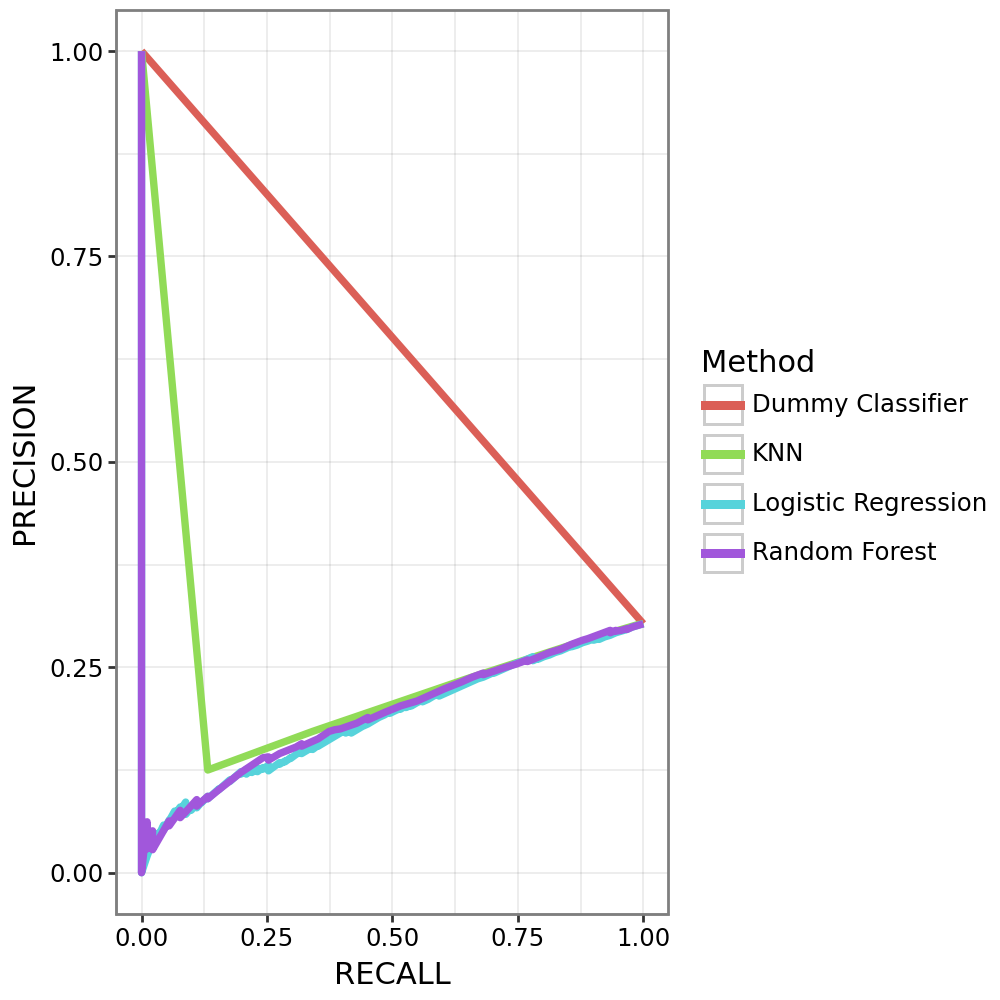

In [31]:
#### YOUR CODE STARTS ####
pr_plot = plot_pr(coordinates_dict)
pr_plot
#### YOUR CODE ENDS ####

<font color='red'>  **(Homework exercise 2- c)** Use sklearn functions `PrecisionRecallDisplay` and `precision_recall_curve` and matplotlib to verify that your curves from 2-b are correct. **(0.5 points)**</font>

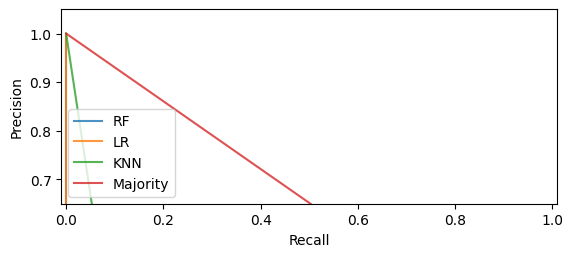

In [32]:
#Importing the required libraries
from sklearn.metrics._plot.precision_recall_curve import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
ax = plt.gca()

#### YOUR CODE STARTS ####
# Compute precision, recall, and thresholds for each model
lr_prec, lr_recall, _ = precision_recall_curve(y_test['class'] == "bad", y_test['logit_prob'])
knn_prec, knn_recall, _ = precision_recall_curve(y_test['class'] == "bad", y_test['knn_prob'])
rf_prec, rf_recall, _ = precision_recall_curve(y_test['class'] == "bad", y_test['rf_prob'])
dummy_prec, dummy_recall, _ = precision_recall_curve(y_test['class'] == "bad", y_test['dummy_prob'])

# Create PrecisionRecallDisplay objects
lr_disp = PrecisionRecallDisplay(precision=lr_prec, recall=lr_recall)
knn_disp = PrecisionRecallDisplay(precision=knn_prec, recall=knn_recall)
rf_disp = PrecisionRecallDisplay(precision=rf_prec, recall=rf_recall)
majority_disp = PrecisionRecallDisplay(precision=dummy_prec, recall=dummy_recall)

#### YOUR CODE ENDS ####
rf_disp.plot(ax=ax, alpha=0.8, drawstyle = 'default', label='RF')
lr_disp.plot(ax=ax, alpha=0.8, drawstyle = 'default', label='LR')
knn_disp.plot(ax=ax, alpha=0.8, drawstyle = 'default', label='KNN')
majority_disp.plot(ax=ax, alpha=0.8, drawstyle = 'default', label='Majority')

ax.set_ylim(0.65, 1.05)
plt.show()

<font color='red'>  **(Homework exercise 2- d)** Create two ensembles: VotingClassifier (with soft voting) and StackingClassifier using previously trained (reasonable) models. Visualise performances of the ensembles using PRCs. Add PRCs from the previous models on the same plot for the comparison. Analyse the resulting plot and provide the interpretation. **(0.5 points)**</font>

In [33]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

#### YOUR CODE STARTS ####
# Define base models (assuming they are already trained)
log_reg = LogisticRegression(max_iter=10000, random_state=13)
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(random_state=13)

# Voting
voting_clf = VotingClassifier(estimators=[('lr', log_reg), ('knn', knn), ('rf', rf)], voting='soft')
voting_clf.fit(X_train_transformed, y_train['class'])

# Stacking
stacking_clf = StackingClassifier(estimators=[('lr', log_reg), ('knn', knn), ('rf', rf)], final_estimator=LogisticRegression())
stacking_clf.fit(X_train_transformed, y_train['class'])

# Compute probabilities for PR curve
voting_prob = voting_clf.predict_proba(X_test_transformed)[:, 1]
stacking_prob = stacking_clf.predict_proba(X_test_transformed)[:, 1]
#### YOUR CODE ENDS ####

<font color='red'> Create PRC coordinates for each model using `generate_PR_coordinates`. </font>

In [34]:
#### YOUR CODE STARTS ####
pr_logit = generate_PR_coordinates(y_test['logit_prob'], y_test['class'], positive_label="bad")
pr_knn = generate_PR_coordinates(y_test['knn_prob'], y_test['class'], positive_label="bad")
pr_rf = generate_PR_coordinates(y_test['rf_prob'], y_test['class'], positive_label="bad")
pr_dummy = generate_PR_coordinates(y_test['dummy_prob'], y_test['class'], positive_label="bad")
pr_voting = generate_PR_coordinates(pd.Series(voting_prob), y_test['class'], positive_label="bad")
pr_stacking = generate_PR_coordinates(pd.Series(stacking_prob), y_test['class'], positive_label="bad")

# Add top row to PRC coordinates for all models
top_row = pd.DataFrame({'PRECISION': 1, 'RECALL': 0}, index=[1.0])
pr_logit = pd.concat([top_row, pr_logit])
pr_knn = pd.concat([top_row, pr_knn])
pr_rf = pd.concat([top_row, pr_rf])
pr_dummy = pd.concat([top_row, pr_dummy])
pr_voting = pd.concat([top_row, pr_voting])
pr_stacking = pd.concat([top_row, pr_stacking])

# Store all PR coordinates in a dictionary
coordinates_dict = {
    "Logistic Regression": pr_logit,
    "KNN": pr_knn,
    "Random Forest": pr_rf,
    "Dummy Classifier": pr_dummy,
    "Voting Classifier": pr_voting,
    "Stacking Classifier": pr_stacking
}
#### YOUR CODE ENDS ####

<font color='red'>  Visualise the resulting PR curves below. </font>

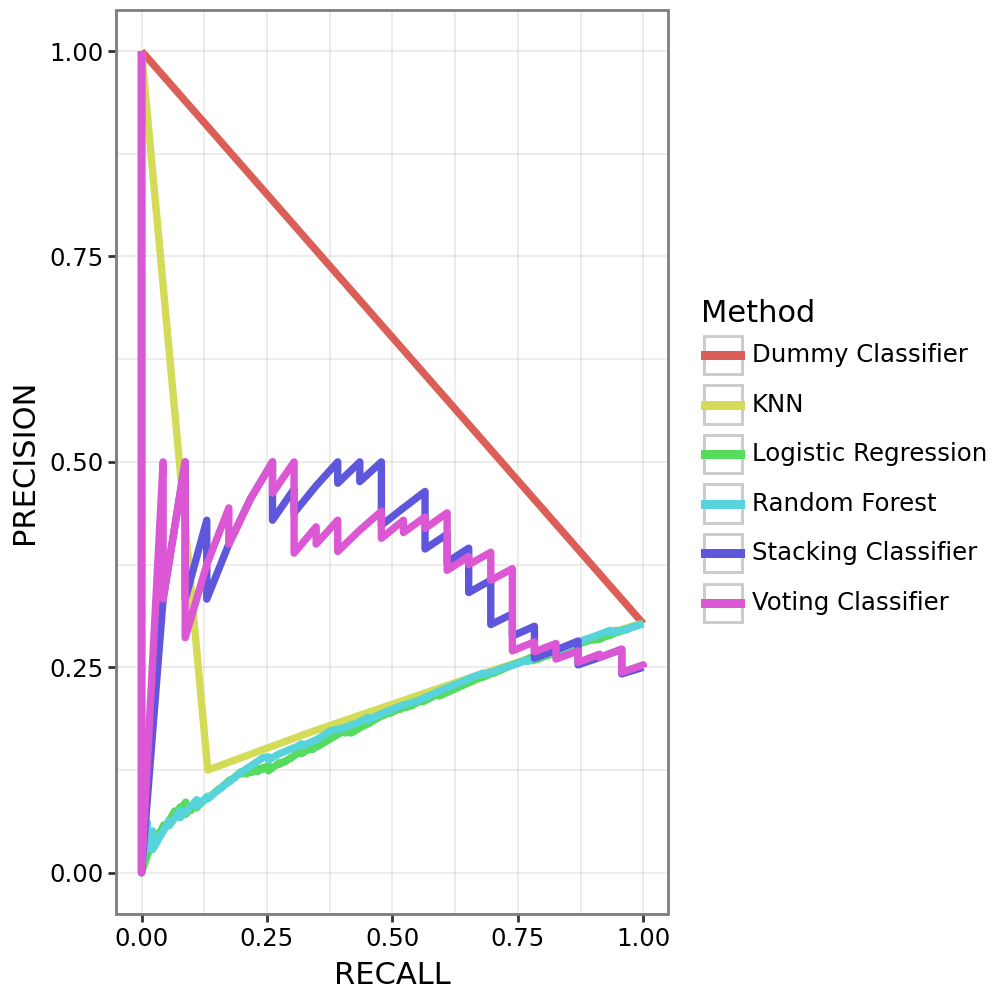

In [35]:
#### YOUR CODE STARTS ####
pr_plot = plot_pr(coordinates_dict)
pr_plot
#### YOUR CODE ENDS ####

<font color='red'>  Analyse the above figure and explain why both stacking and voting models exhibit steep decline in the lower left corner. Your answer: </font>

## Homework exercise 3: improving classifier's performance with dataset balancing (4 points)

<font color='red'>  **(Homework exercise 3- a)** Explore the class distribution of the credit dataset. Train a classifier on the original dataset. Evaluate it on the test set using several performance metrics. Use sklearn for calculating metrics, no need to implement them yourself.  **(1 point)**</font>

<font color='red'> Plot the histogram of the class distribution below to remind ourselves how badly unbalanced the dataset is.</font>

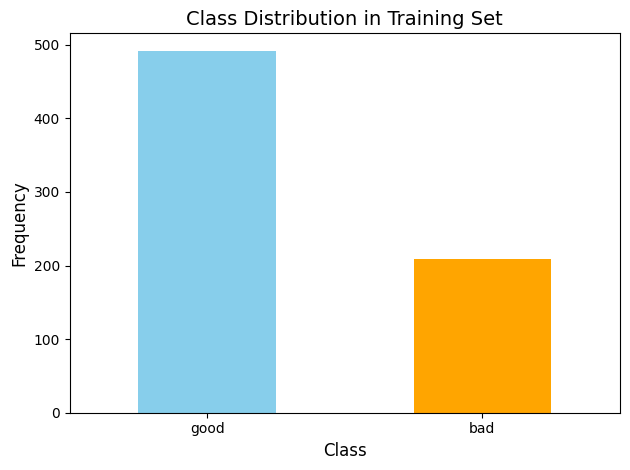

In [36]:
plot_class_distribution(y_train['class'], title="Class Distribution in Training Set")

<font color='red'>  Choose a classifier - **don't use DecisionTreeClassifier**, it only returns 0/1 for probabilities - train it on the training data and predict customer's credict risk (`bad` or `good`) on the test. Again, treat `good` as negative class and `bad` as positive. </font>

In [37]:
#### YOUR CODE STARTS ####
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train_transformed, y_train['class'])
y_pred = classifier.predict(X_test_transformed)
#### YOUR CODE ENDS ####

<font color='red'> Next, write a function `compute_and_print_metrics` where include four different metrics that we have studied in the class + Matthews Correlation Coefficient (also known as Phi coefficient in statistics), here is the [link](https://en.wikipedia.org/wiki/Phi_coefficient). </font>

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.preprocessing import StandardScaler

In [40]:
def compute_and_print_metrics(y_test, y_pred):
  #### YOUR CODE STARTS ####
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Precision (for "bad" class)
    precision = precision_score(y_test, y_pred, pos_label="bad")

    # Recall (for "bad" class)
    recall = recall_score(y_test, y_pred, pos_label="bad")

    # F1 Score (for "bad" class)
    f1 = f1_score(y_test, y_pred, pos_label="bad")

    # Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_test, y_pred)

    # Print all the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (bad as positive): {precision:.4f}")
    print(f"Recall (bad as positive): {recall:.4f}")
    print(f"F1 Score (bad as positive): {f1:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
  #### YOUR CODE ENDS ####

<font color='red'> Use `compute_and_print_metrics` to evaluate the model of your choice. </font>

In [41]:
compute_and_print_metrics(y_test['class'], y_pred)

Accuracy: 0.7033
Precision (bad as positive): 0.5076
Recall (bad as positive): 0.7363
F1 Score (bad as positive): 0.6009
Matthews Correlation Coefficient: 0.3938


<font color='red'>  **(Homework exercise 3- b)** Create three balanced versions of the original dataset using:

*   <font color='red'> Oversampling method </font>
*   <font color='red'> Undersampling method </font>
*   <font color='red'> Combination of Over- and Undersampling methods </font>

Select **only** over- and undersampling methods that we have discussed in the regularisation lecture part II. Retrain your chosen classifier on each of the versions and evaluate on the original test set. Store models trained on different versions of the dataset in different variables, they will be useful for the next task.  **(1 point)** </font>


<font color='red'> Below use an **oversampling** approach. </font>

In [42]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

In [43]:
#### YOUR CODE STARTS ####
# Instantiate SMOTE object
smote = SMOTE(random_state=42)
X_over, y_over = smote.fit_resample(X_train_transformed, y_train['class'])
#### YOUR CODE ENDS ####

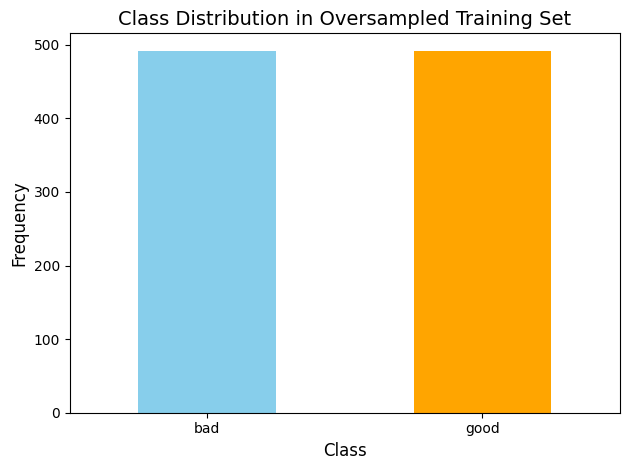

In [44]:
plot_class_distribution(y_over, title="Class Distribution in Oversampled Training Set")

<font color='red'> Re-train your classifier on **oversampled** version of the dataset and use `compute_and_print_metrics` to evaluate it. </font>

In [45]:
#### YOUR CODE STARTS ####
# Re-train classifier on the oversampled version
classifier_over = LogisticRegression(random_state=42)
classifier_over.fit(X_over, y_over)
#### YOUR CODE ENDS ####

LogisticRegression(random_state=42)

In [46]:
y_pred_over = classifier_over.predict(X_test_transformed)
compute_and_print_metrics(y_test['class'], y_pred_over)

Accuracy: 0.7500
Precision (bad as positive): 0.5714
Recall (bad as positive): 0.7033
F1 Score (bad as positive): 0.6305
Matthews Correlation Coefficient: 0.4501


<font color='red'> Below use an **undersampling** approach. </font>

In [47]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
#### YOUR CODE STARTS ####
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X_train_transformed, y_train['class'])
#### YOUR CODE ENDS ####

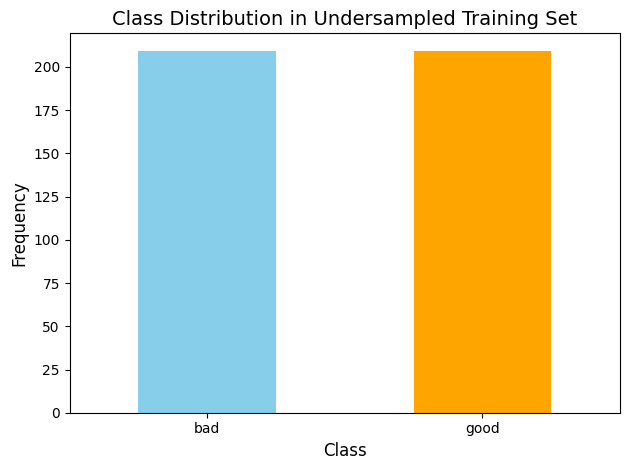

In [48]:
plot_class_distribution(y_under, title="Class Distribution in Undersampled Training Set")

<font color='red'> Re-train your classifier on **undersampled** version of the dataset and use `compute_and_print_metrics` to evaluate it. </font>



In [49]:
#### YOUR CODE STARTS ####
classifier_under = LogisticRegression(random_state=42)
classifier_under.fit(X_under, y_under)
#### YOUR CODE ENDS ####

LogisticRegression(random_state=42)

In [50]:
y_pred_under = classifier_under.predict(X_test_transformed)
compute_and_print_metrics(y_test['class'], y_pred_under)

Accuracy: 0.7233
Precision (bad as positive): 0.5317
Recall (bad as positive): 0.7363
F1 Score (bad as positive): 0.6175
Matthews Correlation Coefficient: 0.4228


<font color='red'> Below use an approach that combines **over-** and **undersampling**. </font>

In [51]:
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression

#### YOUR CODE STARTS ####
smoteenn = SMOTEENN(random_state=42)
X_overunder, y_overunder = smoteenn.fit_resample(X_train_transformed, y_train['class'])
#### YOUR CODE ENDS ####

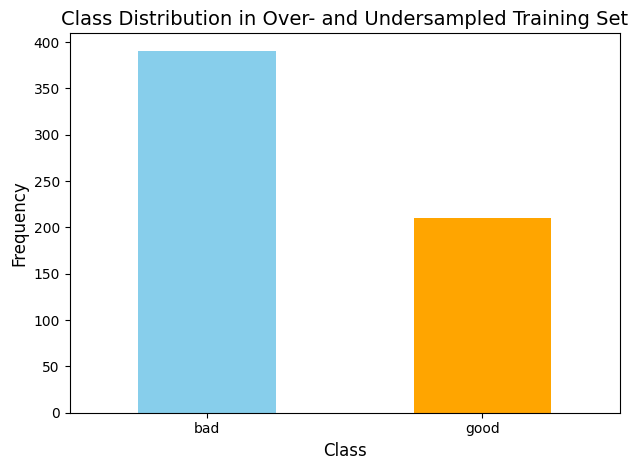

In [52]:
plot_class_distribution(y_overunder, title="Class Distribution in Over- and Undersampled Training Set")

<font color='red'> Re-train your classifier on **over + undersampled** version of the dataset and use `compute_and_print_metrics` to evaluate it. </font>

In [54]:
#### YOUR CODE STARTS ####
classifier_overunder = LogisticRegression(random_state=42)
classifier_overunder.fit(X_overunder, y_overunder)
#### YOUR CODE ENDS ####
y_pred_overunder = classifier_overunder.predict(X_test_transformed)
compute_and_print_metrics(y_test['class'], y_pred_overunder)

Accuracy: 0.6467
Precision (bad as positive): 0.4540
Recall (bad as positive): 0.8132
F1 Score (bad as positive): 0.5827
Matthews Correlation Coefficient: 0.3575


<font color='red'>  **(Homework exercise 3- c)** Visualise ROC and PR curves for all four classifiers you have trained. Generate two plots, one for ROC curves and one for PR curves. **(1 point)**</font>


<font color='red'> Below visualise corresponding **ROC** curves. </font>

In [59]:
# Define classifier names and predicted probabilities
classifiers = [classifier_over, classifier_under, classifier_overunder]
class_names = ['Over-sampling', 'Under-sampling', 'Combined approach']

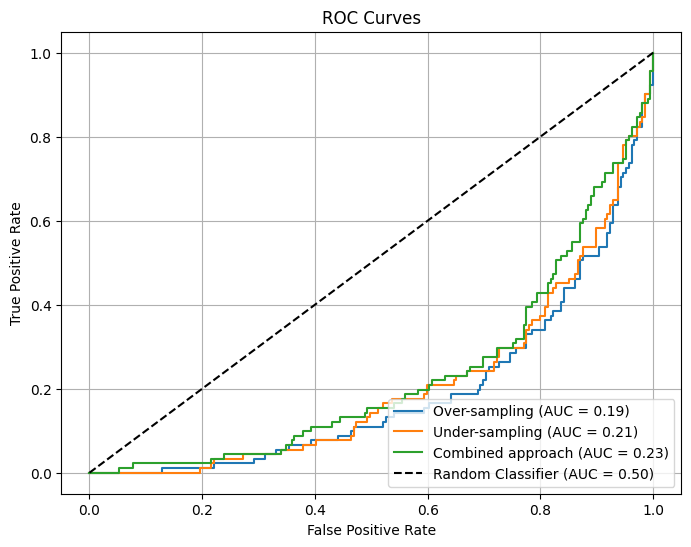

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc # Import roc_curve and auc

# Set up plot for ROC curves
plt.figure(figsize=(8, 6))

# For each classifier, calculate ROC and plot
for classifier, name in zip(classifiers, class_names):
    # Get the predicted probabilities for the positive class
    y_prob = classifier.predict_proba(X_test_transformed)[:, 1]

    # Calculate ROC curve, treating 'bad' as the positive class
    fpr, tpr, _ = roc_curve(y_test['class'], y_prob, pos_label='bad')

    # Calculate AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')

# Add labels and legend
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

<font color='red'> Below visualise corresponding **PR** curves. </font>

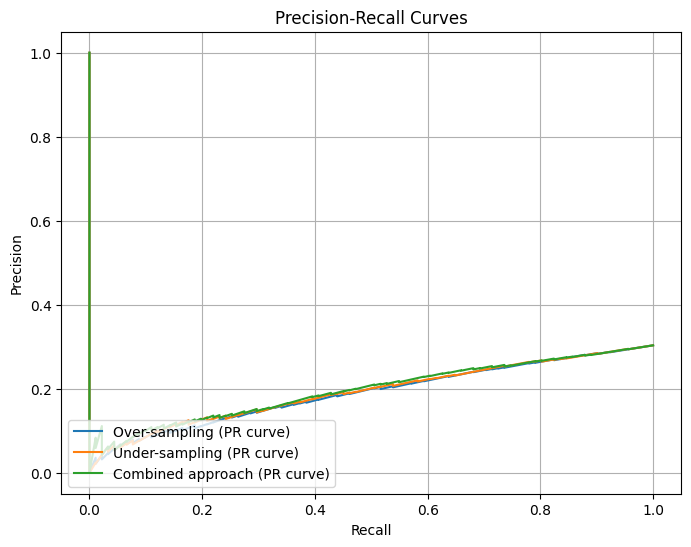

In [62]:
#### YOUR CODE STARTS ####
# Set up plot for PR curves
plt.figure(figsize=(8, 6))

# For each classifier, calculate Precision-Recall curve and plot
for classifier, name in zip(classifiers, class_names):
    # Get the predicted probabilities for the positive class
    y_prob = classifier.predict_proba(X_test_transformed)[:, 1]

    # Calculate Precision-Recall curve, treating 'bad' as the positive class
    precision, recall, _ = precision_recall_curve(y_test['class'], y_prob, pos_label='bad')

    # Plot the PR curve
    plt.plot(recall, precision, label=f'{name} (PR curve)')

# Add labels and legend
plt.title('Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
#### YOUR CODE ENDS ####

<font color='red'>  **(Homework exercise 3- d)** Answer the following questions, make sure to sufficiently but not excessively justify your reasoning (consider `good` to be a negative class):
* <font color='red'> Which metric would you choose if you wanted to minimise the number of people you reject as characterised by `bad` credict risk (e.g. you want to avoid lawsuits)? </font>
* <font color='red'> Which metric would you choose if you wanted to make sure that bank does not give loans to people who potentially cannot return it? </font>
* <font color='red'> Which metrics are a good choice when both types of mistakes should be accounted for on unbalanced data? Mention at least two options. </font>

**(1 point)**</font>

Your answers:
Reducing rejected people who aren't bad credit risks (avoiding lawsuits):
Use Recall. A high recall ensures most "bad" credit risks are correctly identified, so fewer good applicants are mistakenly rejected.

Avoiding loans to people who can't repay:
Use Precision. High precision minimizes mistakes where good applicants are wrongly flagged as bad, ensuring loans are not given to risky applicants.

When both kinds of mistakes matter on unbalanced data:
Use F1-score to balance precision and recall, or Matthews Correlation Coefficient (MCC) for a more comprehensive measure, especially with unbalanced datasets.

# Comments (optional feedback to the course instructors)
Here, please, leave your comments regarding the homework, possibly answering the following questions:
* how much time did you send on this homework?
* was it too hard/easy for you?
* what would you suggest to add or remove?
* anything else you would like to tell us

Your comments:

# <font color='red'>  End of the homework. Please don't delete this cell.</font>